In [ ]:
#Clean install of PyTorch Geometric for Colab
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cu118.html


Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 81.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 124.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 108.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 886.5/886.5 kB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 69.7 MB/s eta 0:00:00


In [ ]:
import torch
from torchvision.io import read_image
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
# import the necessary packages
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage import io
import argparse
import numpy as np
import networkx as nx

In [ ]:
norm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([512, 512])
])


In [ ]:
import cv2

In [ ]:
def super_pixel_graph_construct(img, numSegments=200, sigma=6):
    segments = slic(img, n_segments=numSegments, sigma=sigma, start_label=0)
    regions = segments
    h, w = regions.shape
    _edges = []
    regions_pad = np.pad(regions, [(2, 2), (2, 2)], "constant", constant_values=(-1))

    for i in range(2, h + 2):
        for j in range(2, w + 2):
            region = regions_pad[i, j]
            neighbors = regions_pad[i-2:i+3, j-2:j+3].flatten()
            neighbors = neighbors[[6,7,8,11,13,16,17,18]]
            for tmp in neighbors:
                if tmp != region and tmp != -1:
                    if [region, tmp] not in _edges:
                        _edges.append([region, tmp])

    _edges = np.array(_edges)
    edges = []
    edge_attrs = []
    centers = {}

    for region_idx in np.unique(regions):
        mask = (regions == region_idx)
        y, x = np.where(mask)
        centers[region_idx] = np.array([x.mean(), y.mean()])

    for src, dst in _edges:
        if src in centers and dst in centers:
            edges.append([src, dst])
            dist = np.linalg.norm(centers[src] - centers[dst])  # Euclidean distance
            edge_attrs.append([dist])

    edges = np.array(edges)
    edge_attrs = np.array(edge_attrs)
    return regions, edges, edge_attrs



def get_edge_map(image):
    # Convert to uint8 and grayscale
    gray = cv2.cvtColor((image * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, threshold1=100, threshold2=200)
    return edges / 255.0  # Normalize to [0,1]

def image_to_graph(image, label, numSegments=200):
    edge_map = get_edge_map(image)  # Edge strength map
    regions, edges, edge_attrs = super_pixel_graph_construct(image, numSegments)

    node_features = []
    for region_idx in np.unique(regions):
        mask = (regions == region_idx)
        pixels = image[mask]
        mean_color = pixels.mean(axis=0)

        y_idx, x_idx = np.where(mask)
        x_center = x_idx.mean() / image.shape[1]
        y_center = y_idx.mean() / image.shape[0]

        edge_strength = edge_map[mask].mean()

        feature = np.concatenate([mean_color, [x_center, y_center], [edge_strength]])
        node_features.append(feature)

    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor(edges.T, dtype=torch.long)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.float)  # Required for NNConv
    y = torch.tensor([label], dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)


def plot_superpixel(image, numSegments=100):
    segments = slic(image, n_segments=numSegments, sigma=6, start_label=0)
    fig, ax = plt.subplots()
    ax.imshow(mark_boundaries(image, segments))
    plt.axis("off")
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SuperpixelGraphDataset(Dataset):
    def __init__(self, root_photo, root_sketch, transform=None):
        super().__init__()
        self.images = []
        self.labels = []
        self.transform = transform

        for img_name in os.listdir(root_photo):
            self.images.append(os.path.join(root_photo, img_name))
            self.labels.append(0)

        for img_name in os.listdir(root_sketch):
            self.images.append(os.path.join(root_sketch, img_name))
            self.labels.append(1)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        path = self.images[idx]
        label = int(self.labels[idx])

        im = Image.open(path).convert('RGB')
        if self.transform:
            im = self.transform(im)
        else:
            im = transforms.Resize([128, 128])(im)
            im = transforms.ToTensor()(im)

        image = im.permute(1, 2, 0).numpy()
        graph = image_to_graph(image, label, numSegments=100)
        return graph

In [ ]:
from torch_geometric.loader import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

def get_graph_embeddings(model, loader, device):
    model.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for data1_list, data2_list, label_list in loader:
            for i in range(len(label_list)):
                data1 = data1_list[i].to(device)
                data2 = data2_list[i].to(device)

                # Use encoder from SiameseGCN
                pooled1 = model.encoder(data1.x, data1.edge_index, data1.edge_attr, data1.batch)
                pooled2 = model.encoder(data2.x, data2.edge_index, data2.edge_attr, data2.batch)

                all_embeddings.append(pooled1.cpu().numpy())
                all_embeddings.append(pooled2.cpu().numpy())

                # Append both labels
                all_labels.append(label_list[i])
                all_labels.append(label_list[i])

    embeddings = np.vstack(all_embeddings)
    labels = np.array(all_labels)
    return embeddings, labels


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017Registe

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader

In [ ]:
import os

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool


class GNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_layers=2):
        super(GNN, self).__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(in_dim, hidden_dim))
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, out_dim))
        self.dropout = nn.Dropout(0.5)

    def agg_neighbors(self, x, edge_index):
        num_nodes = x.shape[0]
        agg = torch.zeros_like(x)
        neighbor_count = torch.zeros(num_nodes, dtype=torch.float, device=x.device)
        src_nodes = edge_index[0]
        tgt_nodes = edge_index[1]

        for i in range(edge_index.size(1)):
            src = src_nodes[i]
            tgt = tgt_nodes[i]
            agg[tgt] += x[src]
            neighbor_count[tgt] += 1

        neighbor_count = torch.clamp(neighbor_count, min=1.0)
        agg = agg / neighbor_count.unsqueeze(1)
        return agg

    def forward(self, x, edge_index, batch):
        for i, layer in enumerate(self.layers):
            x = self.agg_neighbors(x, edge_index)
            x = layer(x)
            if i < self.num_layers - 1:
                x = F.relu(x)
                x = self.dropout(x)
        return global_mean_pool(x, batch)  # graph-level output


class SiameseGCN(nn.Module):
    def __init__(self, in_dim, hidden_dim=128, out_dim=128):
        super(SiameseGCN, self).__init__()
        self.gcn = GNN(in_dim, hidden_dim, out_dim)
        self.fc = nn.Linear(out_dim, 64)

    def forward_once(self, data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch
        x = self.gcn(x, edge_index, batch)
        x = self.fc(x)
        return x

    def forward(self, data1, data2):
        out1 = self.forward_once(data1)
        out2 = self.forward_once(data2)
        return out1, out2


In [ ]:
import torch.nn.functional as F

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, z1, z2, label):
        euclidean_distance = F.pairwise_distance(z1, z2)
        loss = label * torch.pow(euclidean_distance, 2) + \
               (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        return loss.mean()


In [ ]:
from torch.utils.data import Dataset
import random

class SiameseGraphDataset(Dataset):
    def __init__(self, base_dataset):
        self.base_dataset = base_dataset

        # Try to access underlying dataset and its labels
        if hasattr(base_dataset, 'labels'):
            labels = base_dataset.labels
        elif hasattr(base_dataset, 'dataset') and hasattr(base_dataset.dataset, 'labels'):
            labels = [base_dataset.dataset.labels[i] for i in base_dataset.indices]
        else:
            raise ValueError("Cannot find labels in base_dataset")

        self.labels = labels
        self.class_to_indices = {0: [], 1: []}
        for idx, label in enumerate(self.labels):
            self.class_to_indices[label].append(idx)

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        graph1 = self.base_dataset[idx]
        label1 = self.labels[idx]

        if random.random() < 0.5:
            # Positive pair
            idx2 = idx
            while idx2 == idx:
                idx2 = random.choice(self.class_to_indices[label1])
            label = 1
        else:
            # Negative pair
            other_label = 1 - label1
            idx2 = random.choice(self.class_to_indices[other_label])
            label = 0

        graph2 = self.base_dataset[idx2]
        return graph1, graph2, label


In [ ]:
import os
import random
import torch
from torch_geometric.data import Dataset

class GraphPairDataset(Dataset):
    def __init__(self, graph_photo_folder, graph_sketch_folder, transform=None, pre_transform=None):
        super().__init__(None, transform, pre_transform)
        self.graph_photo_folder = graph_photo_folder
        self.graph_sketch_folder = graph_sketch_folder

        self.photo_files = sorted(os.listdir(graph_photo_folder))
        self.sketch_files = sorted(os.listdir(graph_sketch_folder))

        self.graph_pairs = []
        self.labels = []

        # ✅ Positive pairs (same filename)
        for filename in self.photo_files:
            if filename in self.sketch_files:
                photo_path = os.path.join(graph_photo_folder, filename)
                sketch_path = os.path.join(graph_sketch_folder, filename)
                self.graph_pairs.append((photo_path, sketch_path))
                self.labels.append(1)  # Positive label

        # ✅ Negative pairs (mismatched sketch)
        positive_names = set(self.sketch_files)
        for filename in self.photo_files:
            # Randomly choose a sketch that's NOT a match
            mismatched_sketches = list(positive_names - {filename})
            if mismatched_sketches:
                sketch_mismatch = random.choice(mismatched_sketches)
                photo_path = os.path.join(graph_photo_folder, filename)
                sketch_path = os.path.join(graph_sketch_folder, sketch_mismatch)
                self.graph_pairs.append((photo_path, sketch_path))
                self.labels.append(0)  # Negative label

    def __len__(self):
        return len(self.graph_pairs)

    def __getitem__(self, idx):
        photo_path, sketch_path = self.graph_pairs[idx]
        photo_graph = torch.load(photo_path)
        sketch_graph = torch.load(sketch_path)
        label = torch.tensor(float(self.labels[idx]), dtype=torch.float)
        return photo_graph, sketch_graph, label


In [ ]:
for i , (g1, g2, label) in enumerate(test_dataset):
    print(f"Pair {i+1}: Label = {label}")


Pair 1: Label = 0
Pair 2: Label = 1
Pair 3: Label = 0
Pair 4: Label = 1
Pair 5: Label = 1
Pair 6: Label = 1
Pair 7: Label = 0
Pair 8: Label = 0


In [ ]:
# Folders where your photo and sketch images are stored
photo_folder = "/content/drive/MyDrive/Datasets/Datasets/front_s2f/face"
sketch_folder = "/content/drive/MyDrive/Datasets/Datasets/front_s2f/skull"

# Define transform (optional)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Base dataset (images → graphs)
base_dataset = SuperpixelGraphDataset(photo_folder, sketch_folder, transform=transform)


IN THIS WE SPLIT DATASET IN 3 TRAING , TESTING AND VALIDATION



In [ ]:
from torch.utils.data import random_split

# Make sure base_dataset is defined earlier
total_size = len(base_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_base, val_base, test_base = random_split(base_dataset, [train_size, val_size, test_size])


In [ ]:
#check your data into test_base test_base.load(test_base)

In [ ]:
train_dataset = SiameseGraphDataset(train_base)
val_dataset = SiameseGraphDataset(val_base)
test_dataset = SiameseGraphDataset(test_base)


In [ ]:
pos_count = sum(label == 1 for label in train_dataset.labels)
neg_count = sum(label == 0 for label in train_dataset.labels)

print(f"✅ Total pairs: {len(train_dataset)}")
print(f"🟢 Positive pairs: {pos_count}")
print(f"🔴 Negative pairs: {neg_count}")


✅ Total pairs: 56
🟢 Positive pairs: 28
🔴 Negative pairs: 28


In [ ]:
# Check if attributes exist
print(hasattr(test_dataset, 'graph_pairs'))  # should be True
print(hasattr(test_dataset, 'labels'))       # should be True


False
True


In [ ]:
print(train_dataset)
print(test_dataset)

In [ ]:
#check you data in test_dataset

In [ ]:
from torch_geometric.loader import DataLoader  # ✅ CORRECT loader for PyG

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)





In [ ]:
sample = next(iter(train_loader))
print(sample[0].x.shape)  # For data1


torch.Size([1596, 6])


In [ ]:
from torch.nn.functional import pairwise_distance

def compute_accuracy(out1, out2, label, threshold=0.7):
    distances = F.pairwise_distance(out1, out2)
    predictions = (distances < threshold).float()
    correct = (predictions == label).float().sum()
    return correct / len(label)


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define this before training
def compute_accuracy(out1, out2, labels, threshold=0.7):
    distances = F.pairwise_distance(out1, out2)
    predictions = (distances < threshold).float()
    correct = (predictions == labels.float()).sum()
    accuracy = correct / labels.size(0)
    return accuracy

# Model, optimizer, loss
model = SiameseGCN(in_dim=6)  # adjust in_dim as needed
criterion = ContrastiveLoss(margin=0.7)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Early stopping setup
best_val_loss = float('inf')
patience = 10
patience_counter = 0
best_model_path = 'best_siamese_gcn.pth'

# Store loss/acc history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(1, 10):  # Change range to 50 or more if needed
    model.train()
    train_loss = 0
    train_correct = 0
    total_train = 0

    for g1, g2, label in train_loader:
        g1, g2, label = g1.to(device), g2.to(device), label.to(device)
        optimizer.zero_grad()
        out1, out2 = model(g1, g2)
        loss = criterion(out1, out2, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        acc = compute_accuracy(out1, out2, label)
        train_correct += acc.item() * label.size(0)
        total_train += label.size(0)

    model.eval()
    val_loss = 0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for g1, g2, label in val_loader:
            g1, g2, label = g1.to(device), g2.to(device), label.to(device)
            out1, out2 = model(g1, g2)
            loss = criterion(out1, out2, label)
            val_loss += loss.item()

            acc = compute_accuracy(out1, out2, label)
            val_correct += acc.item() * label.size(0)
            total_val += label.size(0)

    # Metrics
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_acc = train_correct / total_train
    val_acc = val_correct / total_val

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    # Print progress
    print(f"Epoch {epoch:02d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print("✅ Saved new best model")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏹️ Early stopping triggered")
            break






Epoch 01 | Train Loss: 0.1146 | Val Loss: 0.1076 | Train Acc: 0.4464 | Val Acc: 0.3125
✅ Saved new best model
Epoch 02 | Train Loss: 0.0618 | Val Loss: 0.0372 | Train Acc: 0.5000 | Val Acc: 0.5000
✅ Saved new best model
Epoch 03 | Train Loss: 0.0372 | Val Loss: 0.0128 | Train Acc: 0.4464 | Val Acc: 0.5000
✅ Saved new best model
Epoch 04 | Train Loss: 0.0145 | Val Loss: 0.0071 | Train Acc: 0.6071 | Val Acc: 0.5625
✅ Saved new best model
Epoch 05 | Train Loss: 0.0175 | Val Loss: 0.0101 | Train Acc: 0.8214 | Val Acc: 1.0000
Epoch 06 | Train Loss: 0.0466 | Val Loss: 0.0047 | Train Acc: 0.9286 | Val Acc: 1.0000
✅ Saved new best model
Epoch 07 | Train Loss: 0.0386 | Val Loss: 0.0034 | Train Acc: 0.9821 | Val Acc: 0.8125
✅ Saved new best model
Epoch 08 | Train Loss: 0.0223 | Val Loss: 0.0060 | Train Acc: 0.9107 | Val Acc: 1.0000
Epoch 09 | Train Loss: 0.0250 | Val Loss: 0.0041 | Train Acc: 0.9286 | Val Acc: 0.9375


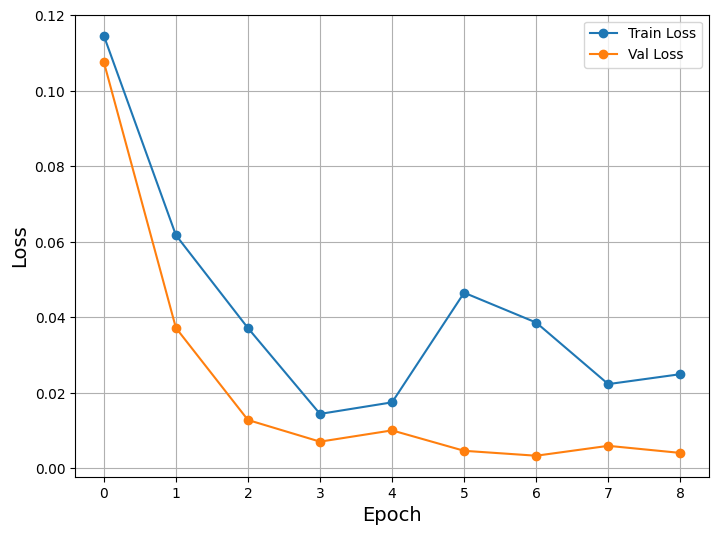

In [ ]:
# Plot Loss and Accuracy
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Loss',fontsize=14)
#plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

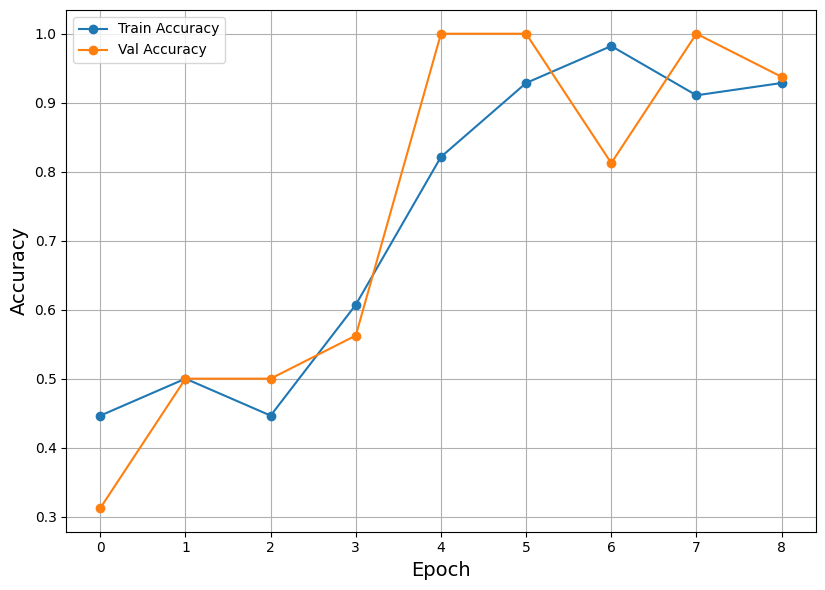

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Val Accuracy', marker='o')
plt.xlabel('Epoch',fontsize = 14)
plt.ylabel('Accuracy',fontsize=14)
#plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Load best model from training
model.load_state_dict(torch.load(best_model_path))
model.eval()


SiameseGCN(
  (gcn): GNN(
    (layers): ModuleList(
      (0): Linear(in_features=6, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=128, bias=True)
    )
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (fc): Linear(in_features=128, out_features=64, bias=True)
)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(model, test_loader, threshold=0.5):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for g1, g2, labels in test_loader:
            g1, g2, labels = g1.to(device), g2.to(device), labels.to(device)
            out1, out2 = model(g1, g2)
            distances = F.pairwise_distance(out1, out2)
            predictions = (distances < threshold).float()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    acc = np.mean(y_pred == y_true)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    return acc, precision, recall, f1, cm


In [ ]:
test_acc, precision, recall, f1, cm = evaluate_model(model, test_loader, threshold=0.5)

print("📊 Test Evaluation Metrics:")
print(f"Accuracy     : {test_acc:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"F1 Score     : {f1:.4f}")
print("Confusion Matrix:")
print(cm)


📊 Test Evaluation Metrics:
Accuracy     : 1.0000
Precision    : 1.0000
Recall       : 1.0000
F1 Score     : 1.0000
Confusion Matrix:
[[4 0]
 [0 4]]


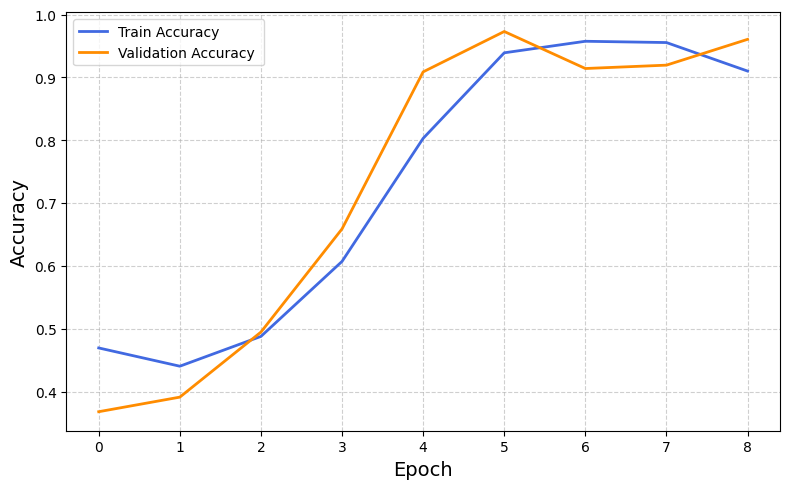

In [ ]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def plot_smoothed_accuracy(train_accuracies, val_accuracies, window=5, polyorder=2):

    if len(train_accuracies) >= window:
        train_smooth = savgol_filter(train_accuracies, window_length=window, polyorder=polyorder)
        val_smooth = savgol_filter(val_accuracies, window_length=window, polyorder=polyorder)
    else:
        train_smooth = train_accuracies
        val_smooth = val_accuracies

    plt.figure(figsize=(8, 5))
    plt.plot(train_smooth, label='Train Accuracy ', color='royalblue', linewidth=2)
    plt.plot(val_smooth, label='Validation Accuracy ', color='darkorange', linewidth=2)
    plt.xlabel("Epoch",fontsize=14)
    plt.ylabel("Accuracy",fontsize=14)
   # plt.title(" Accuracy vs. Epoch")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()




plot_smoothed_accuracy(train_accuracies, val_accuracies)


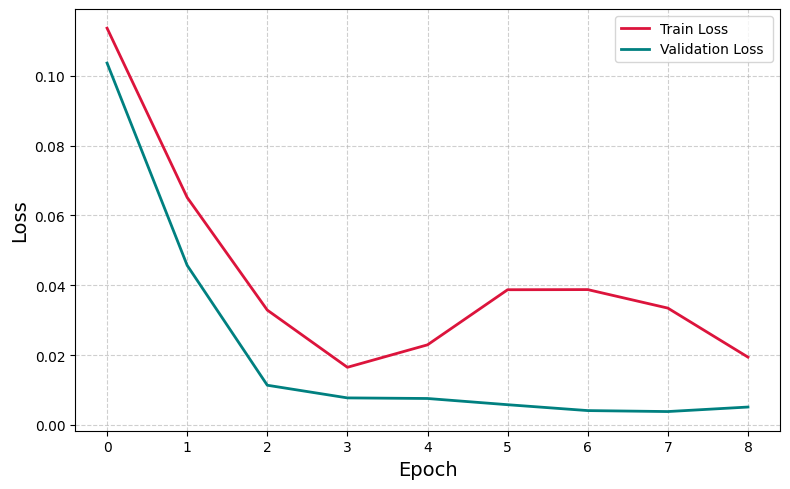

In [ ]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

def plot_smoothed_loss(train_losses, val_losses, window=5, polyorder=2):

    if len(train_losses) >= window:
        train_smooth = savgol_filter(train_losses, window_length=window, polyorder=polyorder)
        val_smooth = savgol_filter(val_losses, window_length=window, polyorder=polyorder)
    else:
        train_smooth = train_losses
        val_smooth = val_losses

    plt.figure(figsize=(8, 5))
    plt.plot(train_smooth, label='Train Loss ', color='crimson', linewidth=2)
    plt.plot(val_smooth, label='Validation Loss ', color='teal', linewidth=2)
    plt.xlabel("Epoch",fontsize=14)
    plt.ylabel("Loss",fontsize=14)
    #plt.title("Loss vs. Epoch")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()




plot_smoothed_loss(train_losses, val_losses)


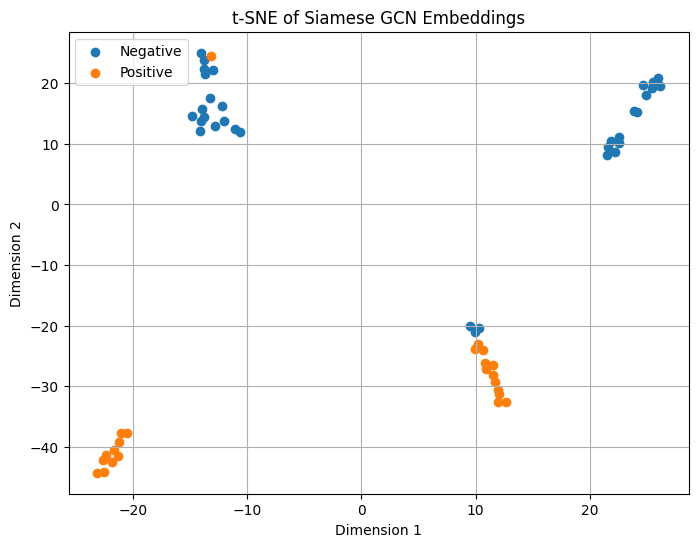

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Load best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

embeddings = []
labels = []

with torch.no_grad():
    for g1, g2, label in train_loader:  # or use val_loader
        g1, g2 = g1.to(device), g2.to(device)
        out1, out2 = model(g1, g2)

        # Average both embeddings or keep separate
        combined = (out1 + out2) / 2  # shape: [batch_size, embedding_dim]
        embeddings.append(combined.cpu().numpy())
        labels.append(label.cpu().numpy())

# Concatenate all batches
embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=min(5, len(embeddings) - 1), random_state=42)

embeddings_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(8, 6))
for lab in np.unique(labels):
    idxs = labels == lab
    plt.scatter(embeddings_2d[idxs, 0], embeddings_2d[idxs, 1], label=f'{"Positive" if lab==1 else "Negative"}')

plt.legend()
plt.title("t-SNE of Siamese GCN Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()


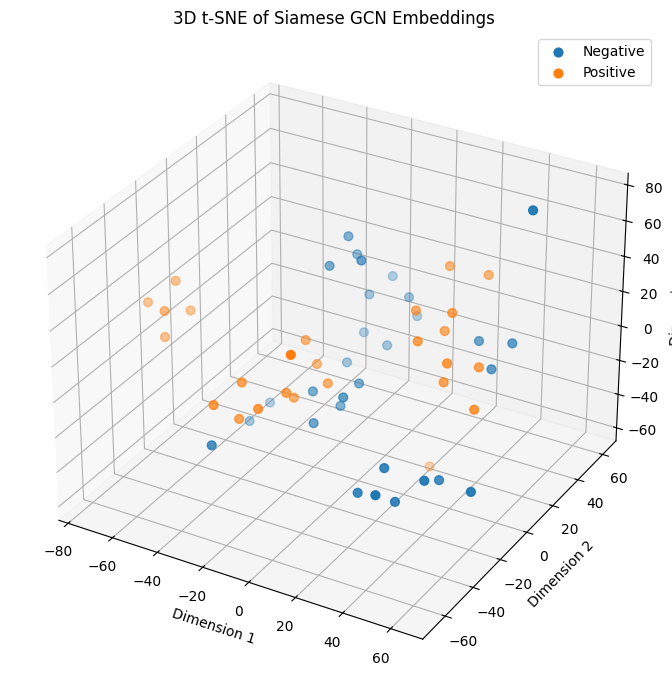

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Load best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

embeddings = []
labels = []

with torch.no_grad():
    for g1, g2, label in train_loader:  # or use val_loader
        g1, g2 = g1.to(device), g2.to(device)
        out1, out2 = model(g1, g2)

        combined = (out1 + out2) / 2
        embeddings.append(combined.cpu().numpy())
        labels.append(label.cpu().numpy())

# Concatenate all batches
embeddings = np.concatenate(embeddings)
labels = np.concatenate(labels)

# Apply t-SNE (3D)
tsne = TSNE(n_components=3, perplexity=min(5, len(embeddings) - 1), random_state=42)
embeddings_3d = tsne.fit_transform(embeddings)

# Plot in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for lab in np.unique(labels):
    idxs = labels == lab
    ax.scatter(
        embeddings_3d[idxs, 0],
        embeddings_3d[idxs, 1],
        embeddings_3d[idxs, 2],
        label=f'{"Positive" if lab == 1 else "Negative"}',
        s=40
    )

ax.set_title("3D t-SNE of Siamese GCN Embeddings")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
ax.legend()
plt.tight_layout()
plt.show()


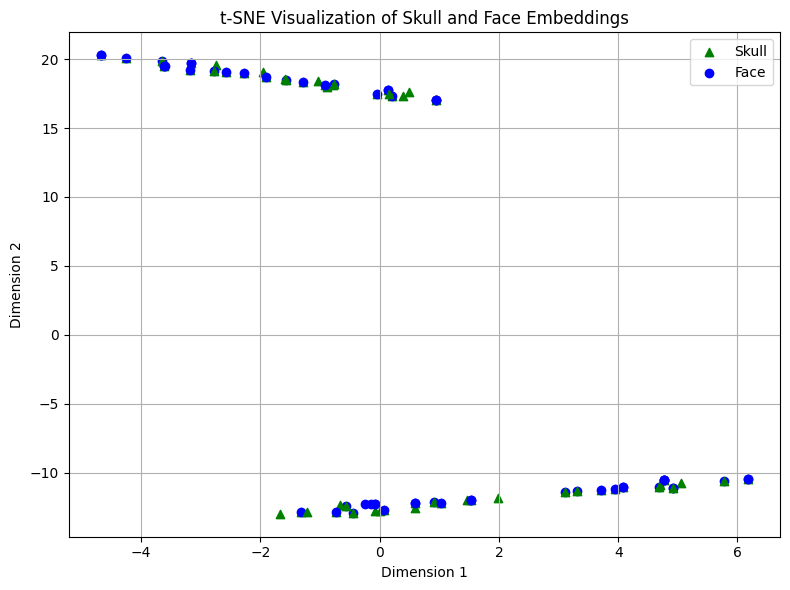

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Load the best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

embeddings = []
types = []  # 'face' or 'skull'

with torch.no_grad():
    for g1, g2, _ in train_loader:
        g1, g2 = g1.to(device), g2.to(device)

        out1, out2 = model(g1, g2)  # Get embeddings

        embeddings.append(out1.cpu().numpy())
        types.extend(['skull'] * out1.shape[0])  # out1 is skull

        embeddings.append(out2.cpu().numpy())
        types.extend(['face'] * out2.shape[0])  # out2 is face

# Stack all embeddings
embeddings = np.vstack(embeddings)

# ✅ Apply t-SNE
tsne = TSNE(n_components=2, perplexity=min(30, len(embeddings) - 1), random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# 🎨 Plot
plt.figure(figsize=(8, 6))
for i, (x, y) in enumerate(embeddings_2d):
    if types[i] == 'face':
        plt.scatter(x, y, c='blue', marker='o', label='Face' if 'Face' not in plt.gca().get_legend_handles_labels()[1] else "")
    else:
        plt.scatter(x, y, c='green', marker='^', label='Skull' if 'Skull' not in plt.gca().get_legend_handles_labels()[1] else "")

plt.title("t-SNE Visualization of Skull and Face Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


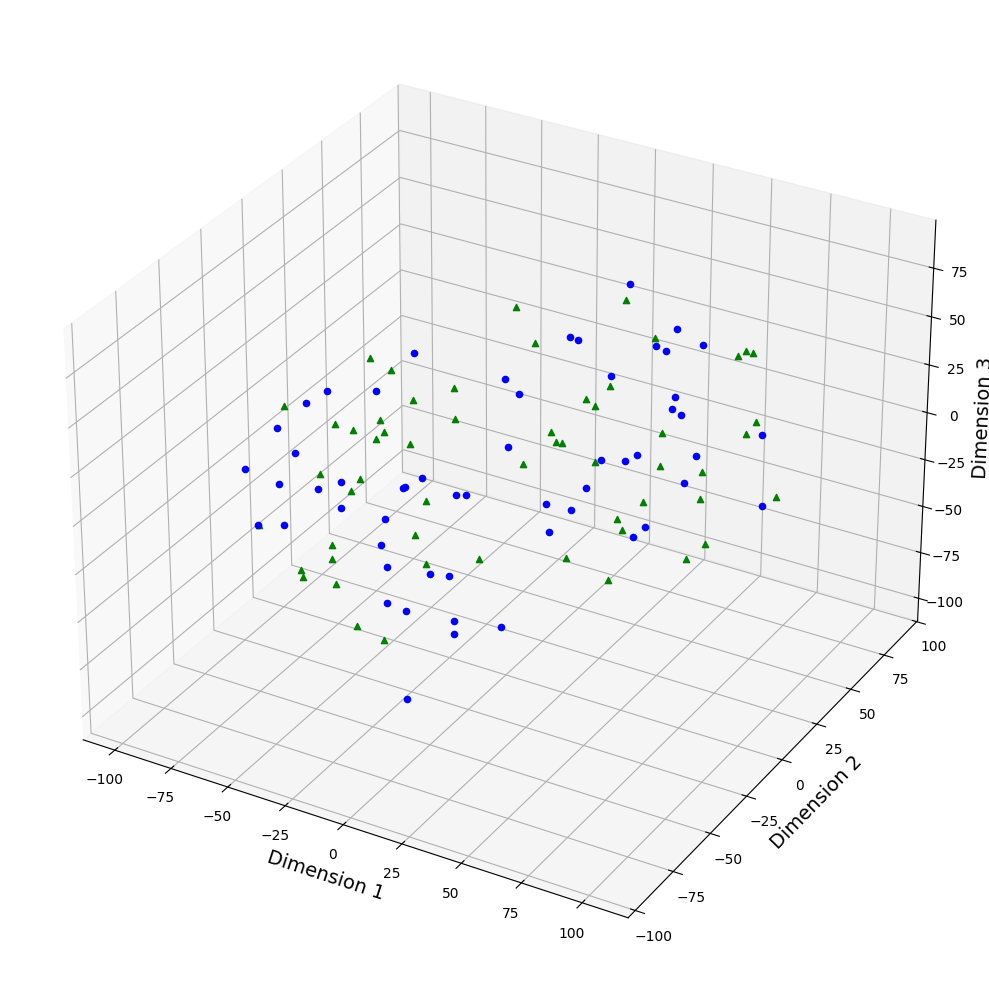

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Load the best model
model.load_state_dict(torch.load(best_model_path))
model.eval()

embeddings = []
types = []  # 'face' or 'skull'

with torch.no_grad():
    for g1, g2, _ in train_loader:
        g1, g2 = g1.to(device), g2.to(device)
        out1, out2 = model(g1, g2)

        embeddings.append(out1.cpu().numpy())
        types.extend(['skull'] * out1.shape[0])

        embeddings.append(out2.cpu().numpy())
        types.extend(['face'] * out2.shape[0])

# Stack all embeddings
embeddings = np.vstack(embeddings)

# Apply 3D t-SNE
tsne = TSNE(n_components=3, perplexity=min(30, len(embeddings)-1), random_state=42)
embeddings_3d = tsne.fit_transform(embeddings)

# 🎨 3D Plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for i, (x, y, z) in enumerate(embeddings_3d):
    if types[i] == 'face':
        ax.scatter(x, y, z, c='blue', marker='o', label='Face' if 'Face' not in ax.get_legend_handles_labels()[1] else "")
    else:
        ax.scatter(x, y, z, c='green', marker='^', label='Skull' if 'Skull' not in ax.get_legend_handles_labels()[1] else "")

#ax.set_title("3D t-SNE of Skull and Face Embeddings")
ax.set_xlabel("Dimension 1",fontsize=14)
ax.set_ylabel("Dimension 2",fontsize=14)
ax.set_zlabel("Dimension 3",fontsize=14)
#ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
margins = [0.2, 0.5, 0.8, 1.0]
thresholds = np.linspace(0.1, 1.5, 15)


In [ ]:
def train_with_margin(margin):
    model = SiameseGCN(in_dim=6).to(device)
    criterion = ContrastiveLoss(margin=margin)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)

    best_val_loss = float('inf')
    for epoch in range(1, 15):  # Increase for full training
        model.train()
        for g1, g2, label in train_loader:
            g1, g2, label = g1.to(device), g2.to(device), label.to(device)
            optimizer.zero_grad()
            out1, out2 = model(g1, g2)
            loss = criterion(out1, out2, label)
            loss.backward()
            optimizer.step()
        # Evaluate on validation set and save best model
        val_loss = 0
        with torch.no_grad():
            for g1, g2, label in val_loader:
                g1, g2, label = g1.to(device), g2.to(device), label.to(device)
                out1, out2 = model(g1, g2)
                loss = criterion(out1, out2, label)
                val_loss += loss.item()

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'best_model_margin_{margin}.pth')
    return f'best_model_margin_{margin}.pth'


In [ ]:
def evaluate_thresholds(model_path):
    model = SiameseGCN(in_dim=6).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    out1_all, out2_all, label_all = [], [], []

    with torch.no_grad():
        for g1, g2, label in val_loader:
            g1, g2 = g1.to(device), g2.to(device)
            o1, o2 = model(g1, g2)
            out1_all.append(o1.cpu())
            out2_all.append(o2.cpu())
            label_all.append(label)

    out1_all = torch.cat(out1_all)
    out2_all = torch.cat(out2_all)
    label_all = torch.cat(label_all)

    results = []
    for thresh in thresholds:
        acc = compute_accuracy(out1_all, out2_all, label_all, threshold=thresh)
        results.append((thresh, acc.item()))
    return results


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from itertools import product

# Custom Contrastive Loss
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, out1, out2, label):
        dist = F.pairwise_distance(out1, out2)
        loss = label * dist.pow(2) + (1 - label) * F.relu(self.margin - dist).pow(2)
        return loss.mean()

# Accuracy function
def compute_accuracy(out1, out2, labels, threshold):
    distances = F.pairwise_distance(out1, out2)
    predictions = (distances < threshold).float()
    correct = (predictions == labels.float()).sum()
    accuracy = correct / labels.size(0)
    return accuracy.item()

# Values to try
margin_values = [0.3, 0.5, 0.7]
threshold_values = [0.3, 0.5, 0.7]

# Loop over all combinations
for margin, threshold in product(margin_values, threshold_values):
    print(f"\n🧪 Margin: {margin}, Threshold: {threshold}\n{'-'*40}")

    model = SiameseGCN(in_dim=6).to(device)
    criterion = ContrastiveLoss(margin)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0004)

    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    for epoch in range(1, 10):  # Adjust number of epochs
        # ----- Training -----
        model.train()
        train_loss = 0
        train_correct = 0
        total_train = 0

        for g1, g2, label in train_loader:
            g1, g2, label = g1.to(device), g2.to(device), label.to(device)
            optimizer.zero_grad()
            out1, out2 = model(g1, g2)
            loss = criterion(out1, out2, label)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_correct += compute_accuracy(out1, out2, label, threshold) * label.size(0)
            total_train += label.size(0)

        # ----- Validation -----
        model.eval()
        val_loss = 0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for g1, g2, label in val_loader:
                g1, g2, label = g1.to(device), g2.to(device), label.to(device)
                out1, out2 = model(g1, g2)
                loss = criterion(out1, out2, label)
                val_loss += loss.item()
                val_correct += compute_accuracy(out1, out2, label, threshold) * label.size(0)
                total_val += label.size(0)

        # Print per epoch
        train_acc = train_correct / total_train
        val_acc = val_correct / total_val
        print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("⏹️ Early stopping")
                break


In [ ]:
model_name = f"siamese_margin{margin}_th{threshold}.pth"
if val_loss < best_val_loss:
    torch.save(model.state_dict(), model_name)


In [ ]:
print(model_name)

In [ ]:
import os
print(os.listdir())


In [ ]:
# Define the same model architecture
model = SiameseGCN(in_dim=6).to(device)

# Load saved weights
model.load_state_dict(torch.load("siamese_margin0.7_th0.7.pth"))
model.eval()

# Use the same margin and threshold
criterion = ContrastiveLoss(margin=0.7)
threshold = 0.7

# Test loop
test_loss = 0
test_correct = 0
total_test = 0

with torch.no_grad():
    for g1, g2, label in test_loader:
        g1, g2, label = g1.to(device), g2.to(device), label.to(device)
        out1, out2 = model(g1, g2)
        loss = criterion(out1, out2, label)
        test_loss += loss.item()
        test_correct += compute_accuracy(out1, out2, label, threshold) * label.size(0)
        total_test += label.size(0)

# Print test performance
avg_test_loss = test_loss / len(test_loader)
test_accuracy = test_correct / total_test
print(f"✅ Final Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
